In [2]:
import pandas as pd
import numpy as np
from pandas import ExcelWriter
import sys
df = pd.read_csv("files_new/all_filtered.csv", sep = "\t", low_memory = False) # len = 17633323

In [3]:
# drop mistake lines in appending original files 
df = df.loc[df["HGMD"] != "HGMD"]
# combine 染色体位置 and HGVS as a new variable
df["loc_HGVS"] = df["染色体位置"].map(str) + df["HGVS"]
df = df.loc[df["loc_HGVS"].notna()]
# check duplicates
dup = df["loc_HGVS"].value_counts()
# delete duplicates by 染色体位置+HGVS
# note: len = 820159 after this step 
df_filtered = df.drop_duplicates("loc_HGVS")
# save duplicates as a col in df
df_dup = pd.DataFrame(dup)
# index = loc_HGVS, added counts in df
df_filtered = df_filtered.set_index("loc_HGVS")
df_filtered["count"] = df_dup

# split REVEL/M-CAP, S/p/M, drop original
df_filtered[['REVEL','M-CAP']]= df_filtered["REVEL/M-CAP"].str.split('/',expand = True)
df_filtered = df_filtered.drop(['REVEL/M-CAP'], 1)
# remove non-meaningful values "-" and "-1.0"
# note: "-" and "-1.0" means NaN in upstream analysis
df_filtered = df_filtered.replace('-', np.nan)
df_filtered = df_filtered.replace('-1.0', np.nan)

# filter out meaningless data
# note: len = 363511 after this step
df_filtered = df_filtered.loc[(df_filtered["SIFT score"].notna()) |
                            (df_filtered["Polyphen2 score"].notna()) |
                            (df_filtered["表型相关度"].notna()) |
                            (df_filtered["Clinvar"].notna()) |
                            (df_filtered["HGMD"].notna()) |
                            (df_filtered["REVEL"].notna()) |
                            (df_filtered["M-CAP"].notna())]

In [4]:
# Clinvar quanlification
Clinvar_result = [None]* len(df_filtered)
count = 0
for i in df_filtered["Clinvar"]:
    if "likely" in str(i) and "benign" in str(i) and "/" in str(i) :
        Clinvar_result[count]= "C_benign/likely_benign"
    elif "likely" in str(i) and "benign" in str(i):
        Clinvar_result[count]= "C_likely_benign"
    elif "benign" in str(i):
        Clinvar_result[count]= "C_benign"
    elif "uncertain" in str(i) and "significance" in str(i):
        Clinvar_result[count]= "C_uncertain_significance"
    elif "conflicting" in str(i) and "interpretations" in str(i):
        Clinvar_result[count]= "C_conflicting_interpretations"
    elif "not" in str(i) and "provided" in str(i):
        Clinvar_result[count]= "C_not_provided"
    elif "likely" in str(i) and "pathogenic" in str(i) and "/" in str(i):
        Clinvar_result[count]= "C_pathogenic/likely_pathogenic"
    elif "likely" in str(i) and "pathogenic" in str(i):
        Clinvar_result[count]= "C_likely_pathogenic"
    elif "pathogenic" in str(i):
        Clinvar_result[count]= "C_pathogenic"
    elif "association" in str(i):
        Clinvar_result[count]= "C_association"
    else:
        Clinvar_result[count]= "C_NaN"
    count += 1

df_filtered["Clinvar"] = Clinvar_result

# 系统结论量化
result_result = [None]* len(df_filtered)
count = 0
for i in df_filtered["系统结论"]:
    if str(i) == "Benign":
        result_result[count]= 0
    elif str(i) == "Likely benign" :
        result_result[count]= 1
    elif str(i) == "Uncertain significance" :
        result_result[count]= 2
    elif str(i) == "Likely pathogenic" :
        result_result[count]= 3
    elif str(i) == "Pathogenic" :
        result_result[count]= 4
    count += 1


In [5]:
# transfer categorical to dummy variables
df_Clinvar_dummy = pd.get_dummies(df_filtered["Clinvar"])
df_filtered["ExonicFunc_refGene"] = df_filtered["ExonicFunc_refGene"].fillna("NaN_ExonicFunc")
df_ExonicFunc_dummy = pd.get_dummies(df_filtered["ExonicFunc_refGene"])
df_filtered["HGMD"] = df_filtered["HGMD"].fillna("NaN_HGMD")
df_HGMD_dummy = pd.get_dummies(df_filtered["HGMD"])


# new df to save training data
df_model = pd.DataFrame()
# location information
df_model["loc"] = df_filtered["染色体位置"]
df_model["HGVS"] = df_filtered["HGVS"]
# outcome
df_model["result"] = result_result
df_model["user_confirm"] = pd.to_numeric(df_filtered["user_confirm"])
# annotations
df_model["SIFT"] = pd.to_numeric(df_filtered["SIFT score"])
df_model["SIFT"] = df_model["SIFT"].fillna(df_model["SIFT"].mean())
df_model["polyphen2"] = pd.to_numeric(df_filtered["Polyphen2 score"])
df_model["polyphen2"] = df_model["polyphen2"].fillna(df_model["polyphen2"].mean())
df_model["REVEL"] = pd.to_numeric(df_filtered["REVEL"])
df_model["REVEL"] = df_model["REVEL"].fillna(df_model["REVEL"].mean())
df_model["M-CAP"] = pd.to_numeric(df_filtered["M-CAP"])
df_model["M-CAP"] = df_model["M-CAP"].fillna(df_model["M-CAP"].mean())
df_model["count"] = pd.to_numeric(df_filtered["count"])
df_model["pheno_score"] = pd.to_numeric(df_filtered["表型相关度"])
df_model["pheno_score"] = df_model["pheno_score"].fillna(df_model["pheno_score"].mean())

# join dummy df to df_model
df_model = df_model.join(df_Clinvar_dummy, how='outer')
df_model = df_model.join(df_ExonicFunc_dummy, how='outer')
df_model = df_model.join(df_HGMD_dummy, how='outer')

In [6]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Index: 363509 entries, chr1:200880702C1orf106:NM_001142569:exon9:c.1081C>T:p.P361S to chrX:106359259RBM41:NM_001171080:exon3:c.151G>A:p.A51T
Data columns (total 40 columns):
loc                               363509 non-null object
HGVS                              363509 non-null object
result                            363509 non-null int64
user_confirm                      363509 non-null int64
SIFT                              363509 non-null float64
polyphen2                         363509 non-null float64
REVEL                             363509 non-null float64
M-CAP                             363509 non-null float64
count                             363509 non-null int64
pheno_score                       363509 non-null float64
C_NaN                             363509 non-null uint8
C_association                     363509 non-null uint8
C_benign                          363509 non-null uint8
C_benign/likely_benign            363509 non-nul

In [93]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Perceptron
from sklearn import metrics
# # df_model_mean
# pathogenic & not pathogenic

df_model_mean_l_b_p = df_model.loc[df_model["result"]>=0]
df_model_mean_l_b_p["p_or_not"] = np.nan
df_model_mean_l_b_p.loc[df_model_mean_l_b_p.result < 3, 'p_or_not'] = "0"
df_model_mean_l_b_p.loc[df_model_mean_l_b_p.result >= 3, 'p_or_not'] = "1"
df_model_mean_l_b_p.loc[df_model_mean_l_b_p.user_confirm < 1, 'c_or_not'] = "0"
df_model_mean_l_b_p.loc[df_model_mean_l_b_p.user_confirm >= 1, 'c_or_not'] = "1"

df_one_model_mean_l_b_p = df_model_mean_l_b_p.sample(frac=0.5)
print(len(df_one_model_mean_l_b_p))

df_two_model_mean_l_b_p = df_model_mean_l_b_p.append(df_one_model_mean_l_b_p)
print(len(df_two_model_mean_l_b_p))
df_two_model_mean_l_b_p = df_two_model_mean_l_b_p.drop_duplicates("HGVS", keep = False)
print(len(df_two_model_mean_l_b_p))

X = df_model_mean_l_b_p[["SIFT","polyphen2","REVEL","M-CAP","count","pheno_score",
                             "C_NaN","C_association","C_benign","C_benign/likely_benign","C_conflicting_interpretations",
                            "C_likely_benign","C_likely_pathogenic","C_not_provided","C_pathogenic",
                             "C_pathogenic/likely_pathogenic", "C_uncertain_significance", "NaN_ExonicFunc",
                            "frameshift deletion", "frameshift insertion", "frameshift substitution",
                            "nonframeshift deletion", "nonframeshift insertion", "nonframeshift substitution",
                            "nonsynonymous SNV", "stopgain","stoploss","synonymous SNV", "unknown","DFP","DM","DM?","DP",
                            "FP","NaN_HGMD","R"]]
y = df_model_mean_l_b_p["p_or_not"]



# apply SMOTE ## accuracy 0.7312295850899104 sensitivity 0.8821182649070808
# from imblearn.over_sampling import SMOTE
# sm = SMOTE(ratio = "auto", kind = "regular")
# X_resampled, y_resampled = sm.fit_sample(X,y)

# apply random down-sampling ## accuracy 0.7379979570990807 sensitivity 0.8788187372708758
# from imblearn.under_sampling import RandomUnderSampler
# rus = RandomUnderSampler(random_state=0)
# X_resampled, y_resampled = rus.fit_resample(X, y)

# # apply Tomek's links
# from imblearn.under_sampling import TomekLinks
# tl = TomekLinks()
# X_resampled, y_resampled = tl.fit_resample(X, y)

# # apply cluster centroids
# from imblearn.under_sampling import ClusterCentroids
# cc = ClusterCentroids(random_state=0)
# X_resampled, y_resampled = cc.fit_resample(X, y)

# from imblearn.under_sampling import AllKNN
# aknn = AllKNN()
# X_resampled, y_resampled = aknn.fit_resample(X, y)

# from imblearn.under_sampling import AllKNN
# aknn = AllKNN()
# X_resampled, y_resampled = aknn.fit_resample(X, y)

# from imblearn.under_sampling import InstanceHardnessThreshold
# iht = InstanceHardnessThreshold()
# X_resampled, y_resampled = iht.fit_resample(X, y)

# from imblearn.ensemble import BalanceCascade
# bc = BalanceCascade()
# X_resampled, y_resampled = bc.fit_resample(X, y)

# from imblearn.under_sampling import RepeatedEditedNearestNeighbours
# renn = RepeatedEditedNearestNeighbours()
# X_resampled, y_resampled = renn.fit_resample(X, y)



181754
545263
180098


In [94]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=0)

sc = StandardScaler()
sc.fit(X_train) 
sc.mean_ 
sc.scale_ 
X_train_std = sc.transform(X_train)

X_test_std = sc.transform(X_test)

In [95]:
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))


lr = LogisticRegression(C=1000.0, random_state=0,solver = 'liblinear')
lr.fit(X_train_std, y_train)
score = lr.score(X_test_std, y_test)
print(score)

0.7336200354161396


In [96]:
predictions = lr.predict(X_test_std)
df_mean_lr_pred = pd.DataFrame(y_test)
df_mean_lr_pred["pred"] = predictions
print(len(df_mean_lr_pred.loc[df_mean_lr_pred.iloc[:,1] == "1"])/len(df_mean_lr_pred.loc[df_mean_lr_pred.iloc[:,0] == "1"]))
print("sensitivity of user marked or not ")

0.8006889763779528
sensitivity of user marked or not 


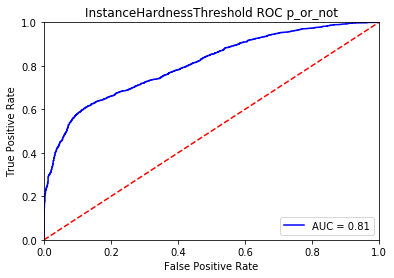

In [97]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = lr.predict_proba(X_test_std)
y_true = y_test.astype(float).reshape(y_test.size,1)

preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_true, preds)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('InstanceHardnessThreshold ROC p_or_not')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.show()

In [60]:
print(len(y_resampled))
len(y)

713844


363509

In [61]:
len(df_model_mean_l_b_p["p_or_not"])

363509

In [118]:
df_two_model_mean_l_b_p["user_confirm"].value_counts()

0    177674
2      1866
1       535
Name: user_confirm, dtype: int64

In [87]:
X = df_model_mean_l_b_p[["SIFT","polyphen2","REVEL","M-CAP","count","pheno_score",
                             "C_NaN","C_association","C_benign","C_benign/likely_benign","C_conflicting_interpretations",
                            "C_likely_benign","C_likely_pathogenic","C_not_provided","C_pathogenic",
                             "C_pathogenic/likely_pathogenic", "C_uncertain_significance", "NaN_ExonicFunc",
                            "frameshift deletion", "frameshift insertion", "frameshift substitution",
                            "nonframeshift deletion", "nonframeshift insertion", "nonframeshift substitution",
                            "nonsynonymous SNV", "stopgain","stoploss","synonymous SNV", "unknown","DFP","DM","DM?","DP",
                            "FP","NaN_HGMD","R"]]
y = df_model_mean_l_b_p["c_or_not"]



# apply SMOTE ## accuracy 0.7312295850899104 sensitivity 0.8821182649070808
# from imblearn.over_sampling import SMOTE
# sm = SMOTE(ratio = "auto", kind = "regular")
# X_resampled, y_resampled = sm.fit_sample(X,y)

# apply random down-sampling ## accuracy 0.7379979570990807 sensitivity 0.8788187372708758
# from imblearn.under_sampling import RandomUnderSampler
# rus = RandomUnderSampler(random_state=0)
# X_resampled, y_resampled = rus.fit_resample(X, y)

# # apply Tomek's links
# from imblearn.under_sampling import TomekLinks
# tl = TomekLinks()
# X_resampled, y_resampled = tl.fit_resample(X, y)

# # apply cluster centroids
# from imblearn.under_sampling import ClusterCentroids
# cc = ClusterCentroids(random_state=0)
# X_resampled, y_resampled = cc.fit_resample(X, y)

# from imblearn.under_sampling import AllKNN
# aknn = AllKNN()
# X_resampled, y_resampled = aknn.fit_resample(X, y)

# from imblearn.under_sampling import AllKNN
# aknn = AllKNN()
# X_resampled, y_resampled = aknn.fit_resample(X, y)

# from imblearn.under_sampling import InstanceHardnessThreshold
# iht = InstanceHardnessThreshold()
# X_resampled, y_resampled = iht.fit_resample(X, y)

# from imblearn.ensemble import BalanceCascade
# bc = BalanceCascade()
# X_resampled, y_resampled = bc.fit_resample(X, y)

# from imblearn.under_sampling import RepeatedEditedNearestNeighbours
# renn = RepeatedEditedNearestNeighbours()
# X_resampled, y_resampled = renn.fit_resample(X, y)

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=0)

sc = StandardScaler()
sc.fit(X_train) 
sc.mean_ 
sc.scale_ 
X_train_std = sc.transform(X_train)

X_test_std = sc.transform(X_test)

In [89]:
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))


lr = LogisticRegression(C=1000.0, random_state=0,solver = 'liblinear')
lr.fit(X_train_std, y_train)
score = lr.score(X_test_std, y_test)
print(score)

0.7336200354161396


In [90]:
predictions = lr.predict(X_test_std)
df_mean_lr_pred = pd.DataFrame(y_test)
df_mean_lr_pred["pred"] = predictions
print(len(df_mean_lr_pred.loc[df_mean_lr_pred.iloc[:,1] == "1"])/len(df_mean_lr_pred.loc[df_mean_lr_pred.iloc[:,0] == "1"]))
print("sensitivity of user marked or not ")

0.8006889763779528
sensitivity of user marked or not 


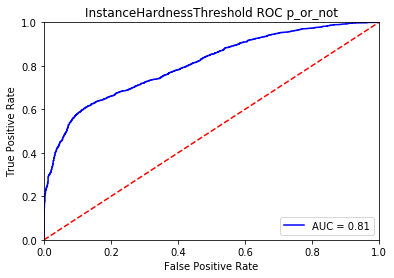

In [91]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = lr.predict_proba(X_test_std)
y_true = y_test.astype(float).reshape(y_test.size,1)

preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_true, preds)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('InstanceHardnessThreshold ROC p_or_not')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.show()

In [68]:
print(len(y_resampled))
len(y)

717512


363509

In [69]:
roc_auc

0.8600854390917461

In [70]:
from sklearn.externals import joblib
# save the model to disk
filename = 'c_or_not_lr_model.sav'
joblib.dump(lr, filename)
scaler_filename = "c_or_not_lr_scalar.sav"
joblib.dump(sc, scaler_filename) 

['c_or_not_lr_scalar.sav']

In [98]:
from sklearn.metrics import confusion_matrix
y_true = df_mean_lr_pred[df_mean_lr_pred.columns[0]]
y_pred = df_mean_lr_pred["pred"]
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
print("tn = "+ str(tn))
print("fp = "+ str(fp))
print("fn = "+ str(fn))
print("tp = "+ str(tp))
print("sensitivity = "+ str(tp / (tp+fn)))
print("specificity = "+ str(tn / (tn+fp)))

tn = 1597
fp = 324
fn = 729
tp = 1303
sensitivity = 0.6412401574803149
specificity = 0.8313378448724622


In [99]:
df_mean_lr_pred

,0,pred
0,1,0
1,1,1
2,0,0
3,1,0
4,1,1
5,0,1
6,1,1
7,1,1
8,0,0
9,1,1
